# Gesture Recognition

We need to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import random as rn
import numpy as np
import cv2
import datetime
import os

In [2]:
# From keras
from tensorflow.keras.utils import plot_model
from keras.applications import InceptionV3
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, we read the folder names for training and validation. We also set the `batch_size` here and we have to set the batch size in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(r'E:\Applications\Git\deep_learning\gesture_detection\Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'E:\Applications\Git\deep_learning\gesture_detection\Project_data/val.csv').readlines())

## Preview 

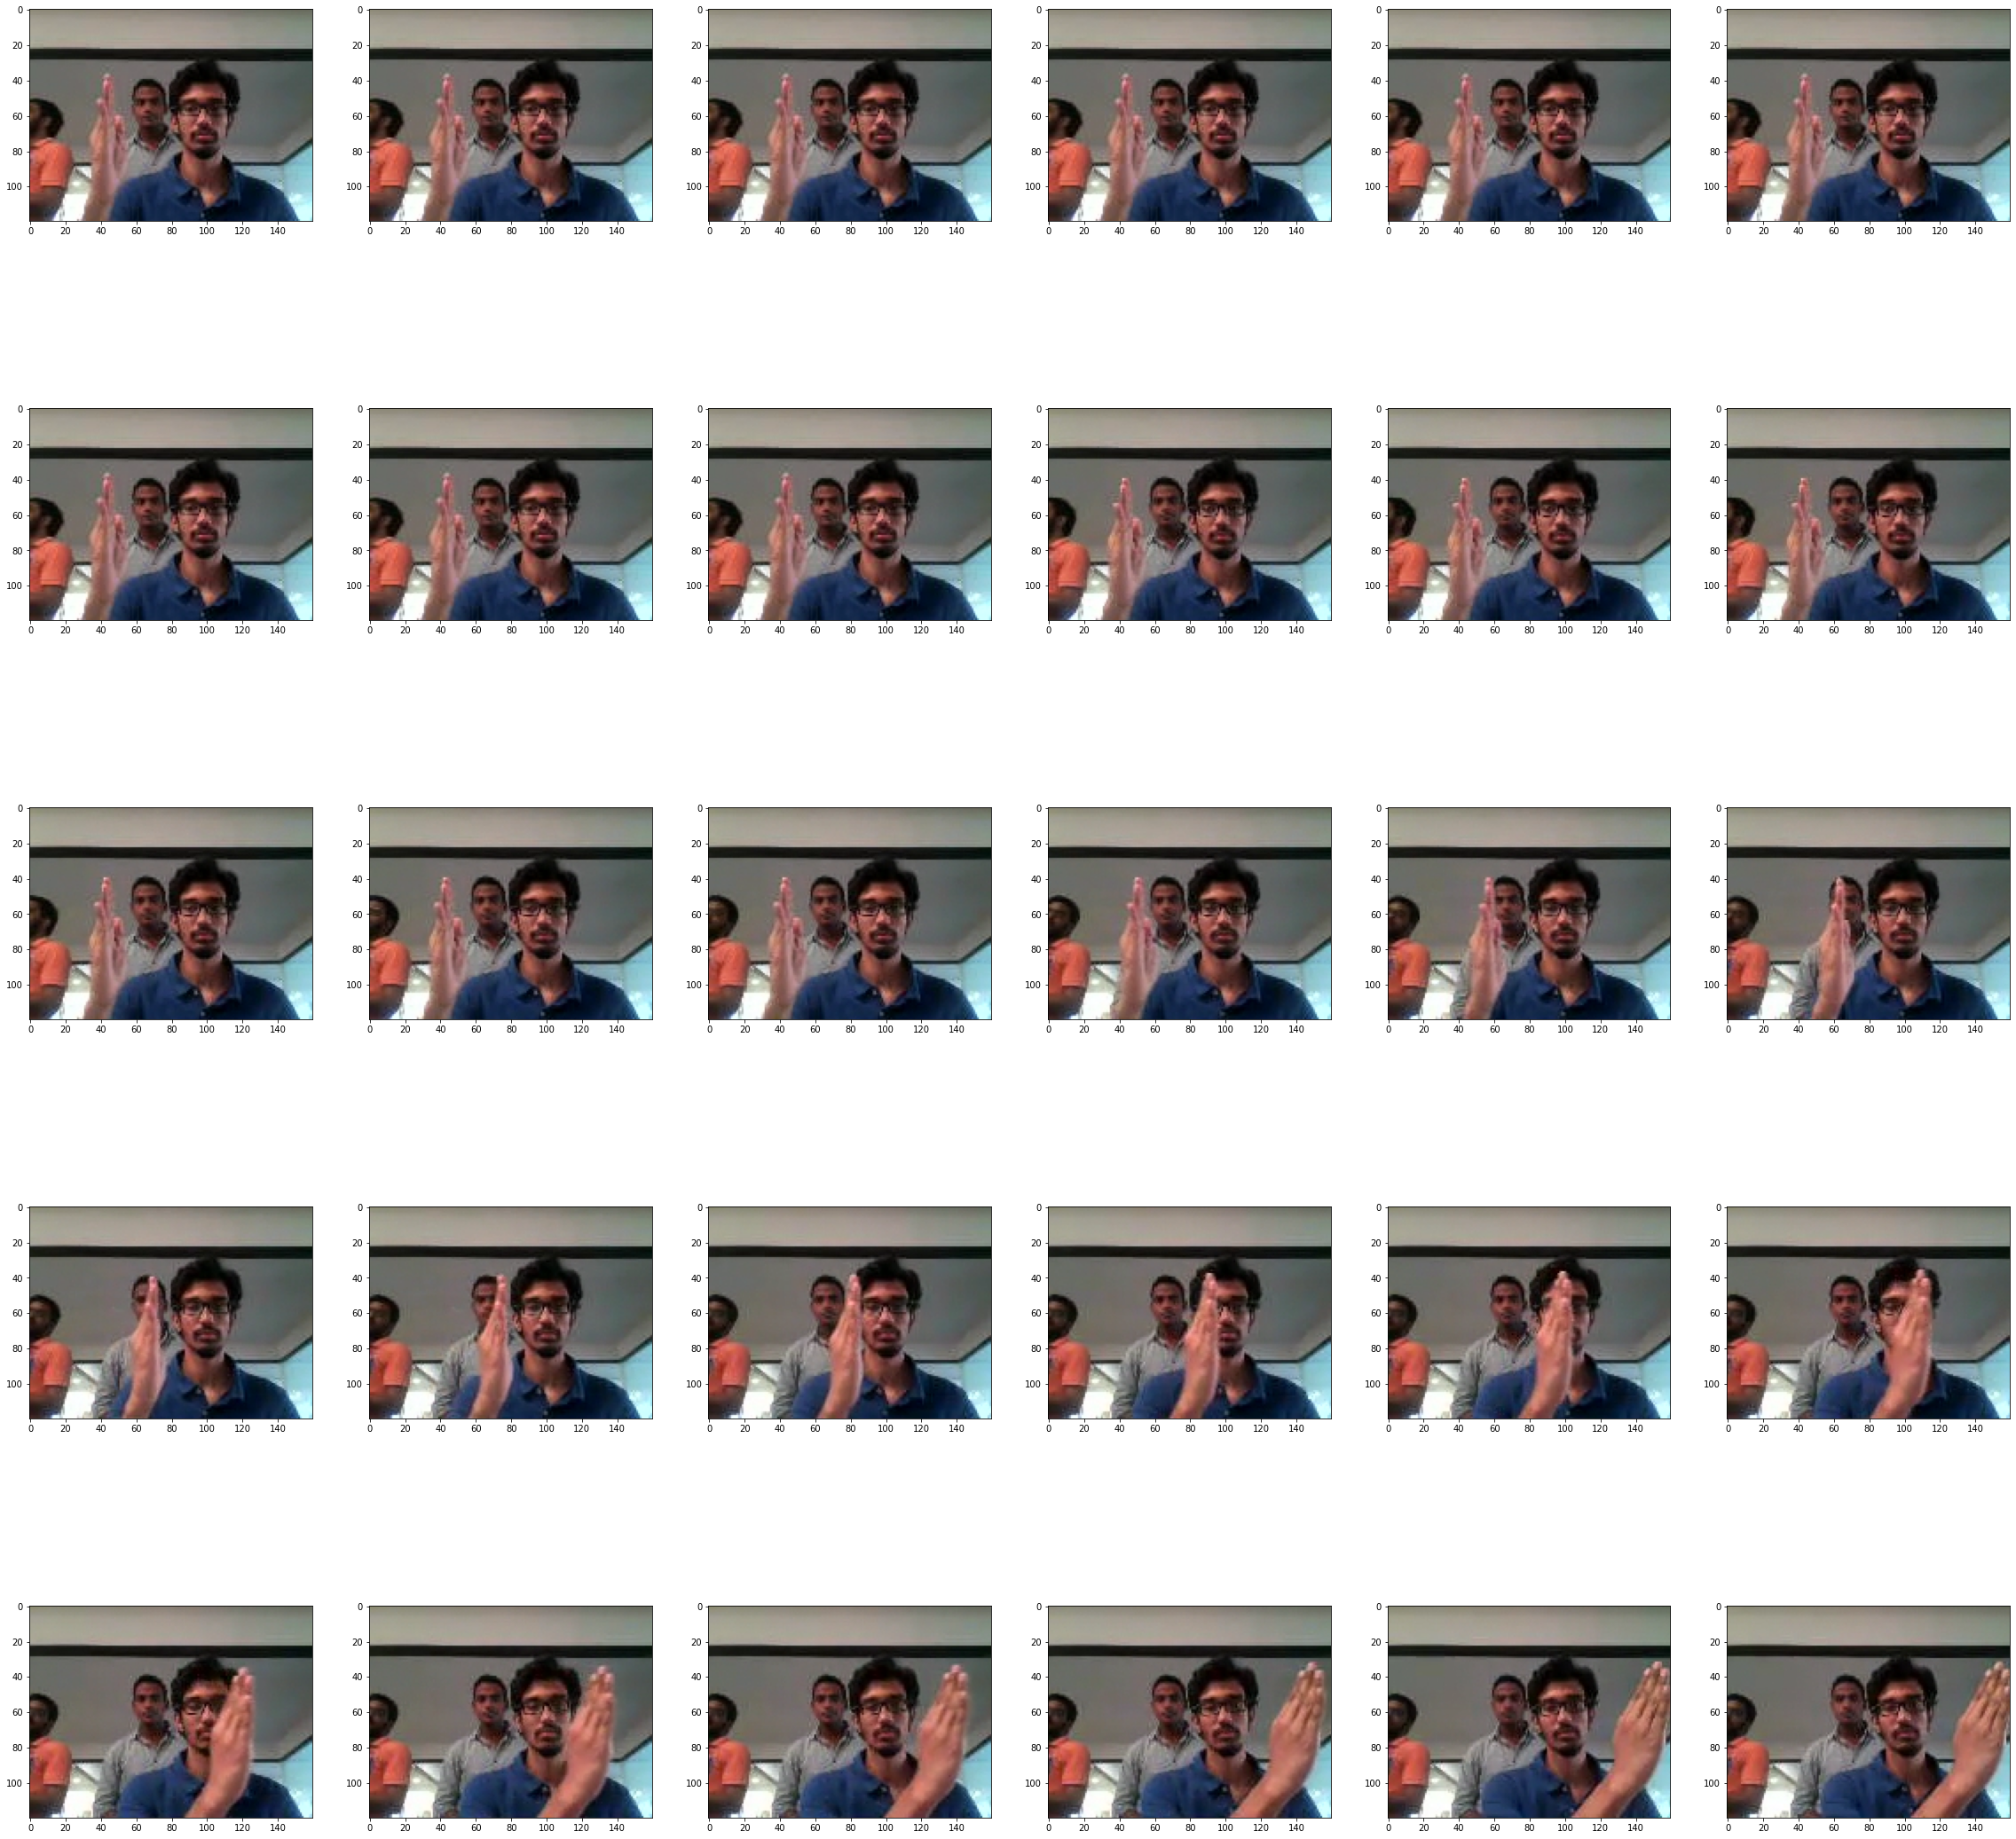

In [87]:
preview_path = os.path.join(r'E:\Applications\Git\deep_learning\gesture_detection\Project_data\train', train_doc[np.random.randint(len(train_doc))].split(';')[0])
sequences = os.listdir(preview_path)

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(40,40))
axes = axes.flatten()

for axis,img_name in zip(axes,sequences):
    img = cv2.imread(preview_path + '/' + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axis.imshow(img)

As we can see we have total of 30 frames for each video to represent the gesture.

## Generator
This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size=8, image_height=64, image_width=64, img_idx=list(range(30))):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = image_height
    z = image_width
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. The images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized = cv2.resize(image, (y, z))
                    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
                    
                    image_r = image_rgb[:,:,0]
                    image_g = image_rgb[:,:,1]
                    image_b = image_rgb[:,:,2]
                    
                    image_r_norm = (image_r - np.min(image_r)) / (np.max(image_r) - np.min(image_r))
                    image_g_norm = (image_g - np.min(image_g)) / (np.max(image_g) - np.min(image_g))
                    image_b_norm = (image_b - np.min(image_b)) / (np.max(image_b) - np.min(image_b))
                    
                    batch_data[folder,idx,:,:,0] = image_r_norm #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_g_norm #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_b_norm #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # yield the batch_data and the batch_labels

        
        # The code for the remaining data points which are left after full batches
        remaining_batch_size = len(folder_list) % batch_size
        completed_sequence_size = len(folder_list) - remaining_batch_size
        
        batch_data = np.zeros((remaining_batch_size,x,y,z,3)) # x is the number of images we use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output
        
        for index, folder in enumerate(range(completed_sequence_size, completed_sequence_size+remaining_batch_size)): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. The images are of 2 different shape and the conv3D will 
                    # throw error if the inputs in a batch have different shapes
                    
                    image_resized = cv2.resize(image, (y, z))
                    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
                    
                    image_r = image_rgb[:,:,0]
                    image_g = image_rgb[:,:,1]
                    image_b = image_rgb[:,:,2]
                    
                    image_r_norm = (image_r - np.min(image_r)) / (np.max(image_r) - np.min(image_r))
                    image_g_norm = (image_g - np.min(image_g)) / (np.max(image_g) - np.min(image_g))
                    image_b_norm = (image_b - np.min(image_b)) / (np.max(image_b) - np.min(image_b))
                    
                    batch_data[index,idx,:,:,0] = image_r_norm #normalise and feed in the image
                    batch_data[index,idx,:,:,1] = image_g_norm #normalise and feed in the image
                    batch_data[index,idx,:,:,2] = image_b_norm #normalise and feed in the image
                    
                batch_labels[index, int(t[folder].strip().split(';')[2])] = 1
        yield batch_data, batch_labels # yield the batch_data and the batch_labels

The video is represented above in the generator as (number of images, height, width, number of channels). We should Take this into consideration while creating the model architecture.

## Train & validation paths

In [6]:
train_path = r'E:\Applications\Git\deep_learning\gesture_detection\Project_data\train'
val_path = r'E:\Applications\Git\deep_learning\gesture_detection\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model Building
Here we make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. The last layer will be the softmax. We will design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model Setup

We can do some model setup so that we don't need to write codes again and again

##### `train_generator` & `val_generator`

Let us create the `train_generator` and the `val_generator` which will be used in `Model.fit`.

In [7]:
def generator_function(batch_size, image_height, image_width):
    
    train_generator = generator(train_path, train_doc, batch_size, image_height=image_height, image_width=image_width)
    val_generator = generator(val_path, val_doc, batch_size, image_height=image_height, image_width=image_width)
    
    return train_generator, val_generator

##### `keras callback`

Let us create the `ModelCheckpoint` and the `ReduceLROnPlateau` callbacks which will be used in `Model.fit`.

In [8]:
def callback_function():
    
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
    callbacks_list = [checkpoint, LR]
    
    return callbacks_list

##### `steps_per_epoch` and `validation_steps`

The `steps_per_epoch` and `validation_steps` are used by `Model.fit` to decide the number of next() calls it need to make.

In [9]:
def steps_per_epocs_function(batch_size):
    
    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / batch_size)
    else:
        steps_per_epoch = (num_train_sequences // batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences / batch_size)
    else:
        validation_steps = (num_val_sequences // batch_size) + 1
        
    return steps_per_epoch, validation_steps

##### `model_params`

Let's use this `model_params` function to call all the above model setup functions. So that we can simply call this function to retrive all the necessary parameters required to build model.

In [10]:
def model_params(batch_size=8, num_epochs=20, optimiser='adam', loss='categorical_crossentropy', eva_metrics='categorical_accuracy', image_height=64, image_width=64):
    
    train_generator, val_generator = generator_function(batch_size=batch_size, image_height=image_height, image_width=image_width)
    callbacks_list = callback_function()
    steps_per_epoch, validation_steps = steps_per_epocs_function(batch_size=batch_size)
    
    batch_size = batch_size 
    num_epochs = num_epochs
   
    model.compile(optimizer=optimiser, loss=loss, metrics=[eva_metrics])
    
    return train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps

### Base Model

Let's create a base model with minimal parameter to test if our model setup works. Then we can do our experimentation.

In [11]:
def base_model(seq_length=30, image_height=64, image_width=64, n_channels=3): 
    
    model = Sequential()

    model.add(Conv3D(16, (3, 3, 3), padding='same',
             input_shape=(seq_length,image_height,image_width,n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    
    return model

Now that you have build our base model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
batch_size = 8
num_epochs = 2

model = base_model()
train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps = model_params(batch_size=batch_size, num_epochs=num_epochs)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 64, 64, 16)    1312      
                                                                 
 activation (Activation)     (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 30, 64, 64, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 21, 21, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 21, 21, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 21, 21, 32)    0

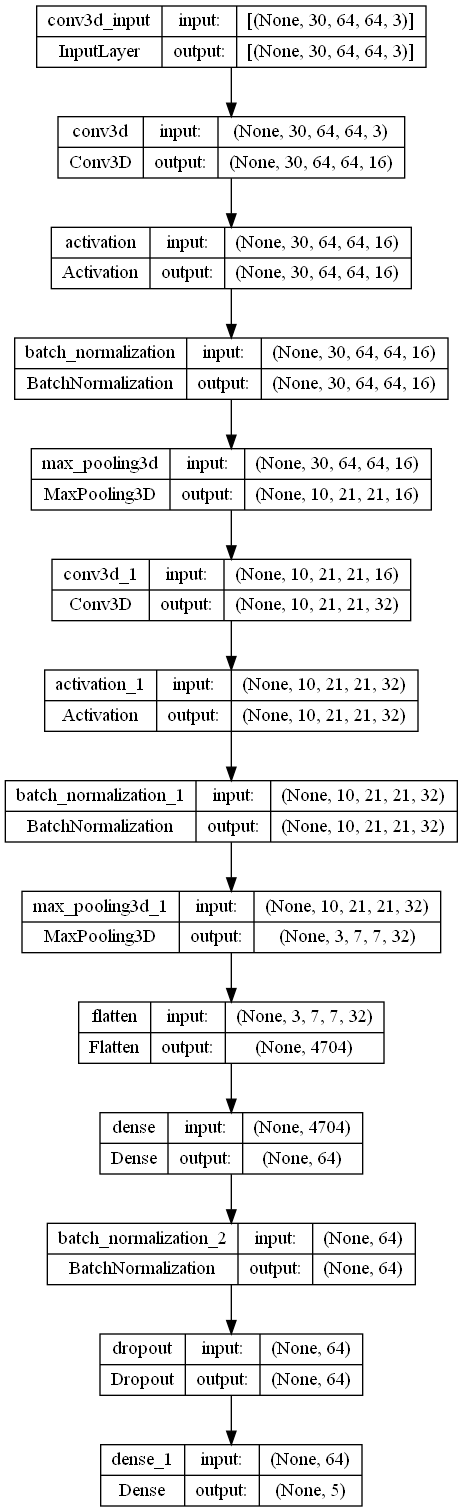

In [13]:
plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\train ; batch size = 8
Epoch 1/2
83/83 [==============================] - ETA: 0s - loss: 1.2970 - categorical_accuracy: 0.4932Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\val ; batch size = 8

Epoch 1: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_2022-07-1212_39_56.113872\model-00001-1.29704-0.49321-5.43484-0.16000.h5
83/83 [==============================] - 38s 418ms/step - loss: 1.2970 - categorical_accuracy: 0.4932 - val_loss: 5.4348 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
83/83 [==============================] - ETA: 0s - loss: 0.8395 - categorical_accuracy: 0.6863
Epoch 2: val_categorical_accuracy did not improve from 0.16000
83/83 [==============================] - 38s 461ms/step - loss: 0.8395 - categorical_accuracy: 0.6863 - val_loss: 8.2591 - val_categorical_accuracy: 0.1400 - lr: 0.0010


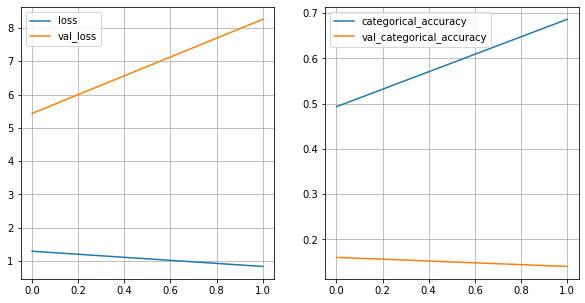

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

We have build our base model with 2 epochs and batch size as 8. It's over fitting since the training accuracy is 0.68 whereas val accuracy is 0.14 and that is totally fine as we have added only few layers and model build for only 2 epochs.

### Let's start doing the expirementation.

### Model - 1

Let's update the below changes to our base model and see.

- Batch size - 64
- Image resolution - 128*128
- Conv3D layer - 3
- MaxPooling3D filter size - 2 
- Dense - 128

In [16]:
def model_1(seq_length=30, image_height=64, image_width=64, n_channels=3): 
    
    model = Sequential()

    model.add(Conv3D(16, (3, 3, 3), padding='same',
             input_shape=(seq_length,image_height,image_width,n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [17]:
batch_size = 64
num_epochs = 2
image_height = 128
image_width = 128

model = model_1(image_height=image_height, image_width=image_width)
train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps = model_params(batch_size=batch_size, num_epochs=num_epochs,image_height=image_height, image_width=image_width)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 30, 128, 128, 16)  1312      
                                                                 
 activation_2 (Activation)   (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization_3 (Batc  (None, 30, 128, 128, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 15, 64, 64, 16)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_3 (Activation)   (None, 15, 64, 64, 32)   

In [19]:
# model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

We got 'ResourceExhaustedError' with image resolution of 128x128 with 30 frames and batch_size of 64. So the above Model.fit is commented out. 

### Model - 2

Let's tradeoff between some of the parameters. We can adjust the batch size to low as possible and reduce Image resolution to half from the Model 1 and do a test run for 2 epocs.

- Batch size - 8
- Image resolution - 64*64
- Conv3D layer - 3
- MaxPooling3D filter size - 3 
- Dense - 128

In [20]:
def model_2(seq_length=30, image_height=64, image_width=64, n_channels=3): 
    
    model = Sequential()

    model.add(Conv3D(16, (3, 3, 3), padding='same',
             input_shape=(seq_length,image_height,image_width,n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [21]:
batch_size = 8
num_epochs = 2
image_height = 64
image_width = 64

model = model_2(image_height=image_height, image_width=image_width)
train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps = model_params(batch_size=batch_size, num_epochs=num_epochs,image_height=image_height, image_width=image_width)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_5 (Activation)   (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_7 (Batc  (None, 30, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 15, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_6 (Activation)   (None, 15, 32, 32, 32)   

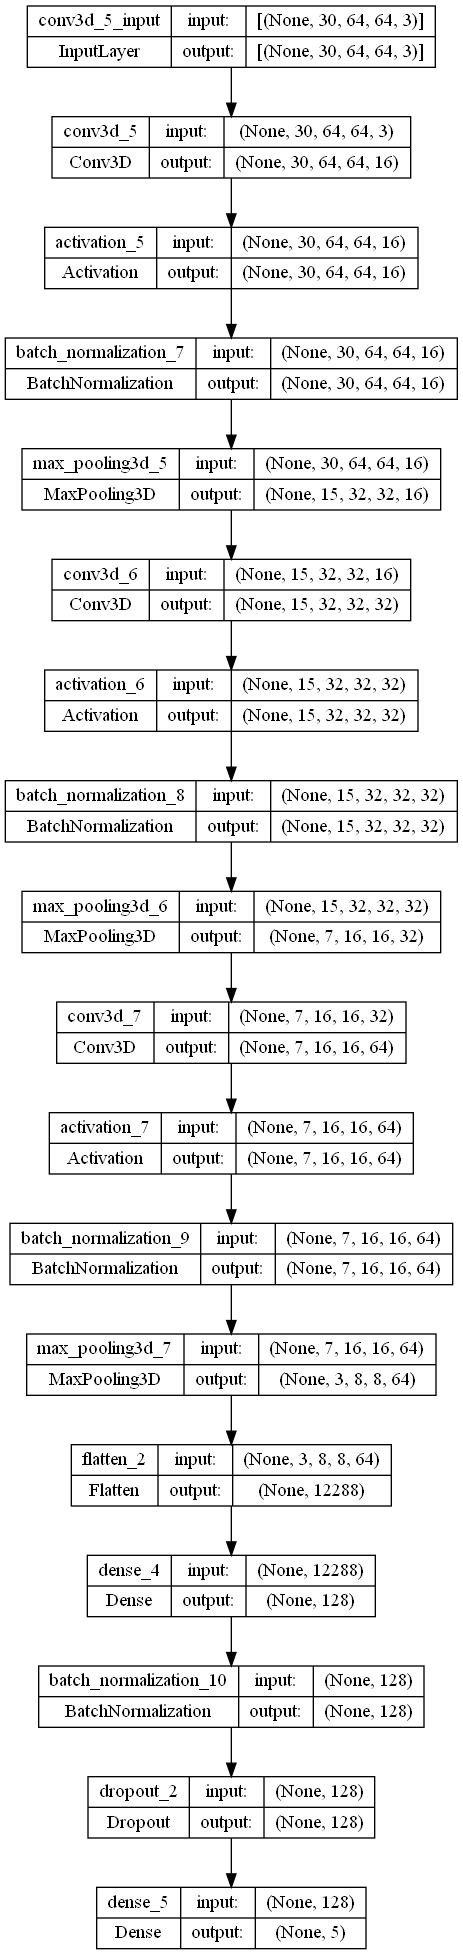

In [22]:
plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\train ; batch size = 8
Epoch 1/2
83/83 [==============================] - ETA: 0s - loss: 1.3631 - categorical_accuracy: 0.5128Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\val ; batch size = 8

Epoch 1: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_2022-07-1212_41_13.597521\model-00001-1.36309-0.51282-16.72361-0.16000.h5
83/83 [==============================] - 35s 419ms/step - loss: 1.3631 - categorical_accuracy: 0.5128 - val_loss: 16.7236 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
83/83 [==============================] - ETA: 0s - loss: 0.6990 - categorical_accuracy: 0.7376
Epoch 2: val_categorical_accuracy improved from 0.16000 to 0.17000, saving model to model_init_2022-07-1212_41_13.597521\model-00002-0.69901-0.73756-18.56194-0.17000.h5
83/83 [==============================] - 35s 429ms/step - loss: 0.6990 - categori

So with batch size as 8 and Image resolution as (64 * 64) we are not running into the memory issue. So Lets build the model for more epocs and see if we are getting good results.

### Model - 3

Let's tweak the architecture of the model-2 little bit by adding one more conv3D layer and Dense layer to get higher performance.

In [25]:
def model_3(seq_length=30, image_height=64, image_width=64, n_channels=3): 

    model = Sequential()
    
    model.add(Conv3D(16, (3, 3, 3), padding='same',
             input_shape=(seq_length,image_height,image_width,n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))
    
    return model

In [26]:
batch_size = 8
num_epochs = 25
image_height = 64
image_width = 64

model = model_3(image_height=image_height, image_width=image_width)
train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps = model_params(batch_size=batch_size, num_epochs=num_epochs,image_height=image_height, image_width=image_width)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_8 (Activation)   (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_11 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 32, 32, 32)   

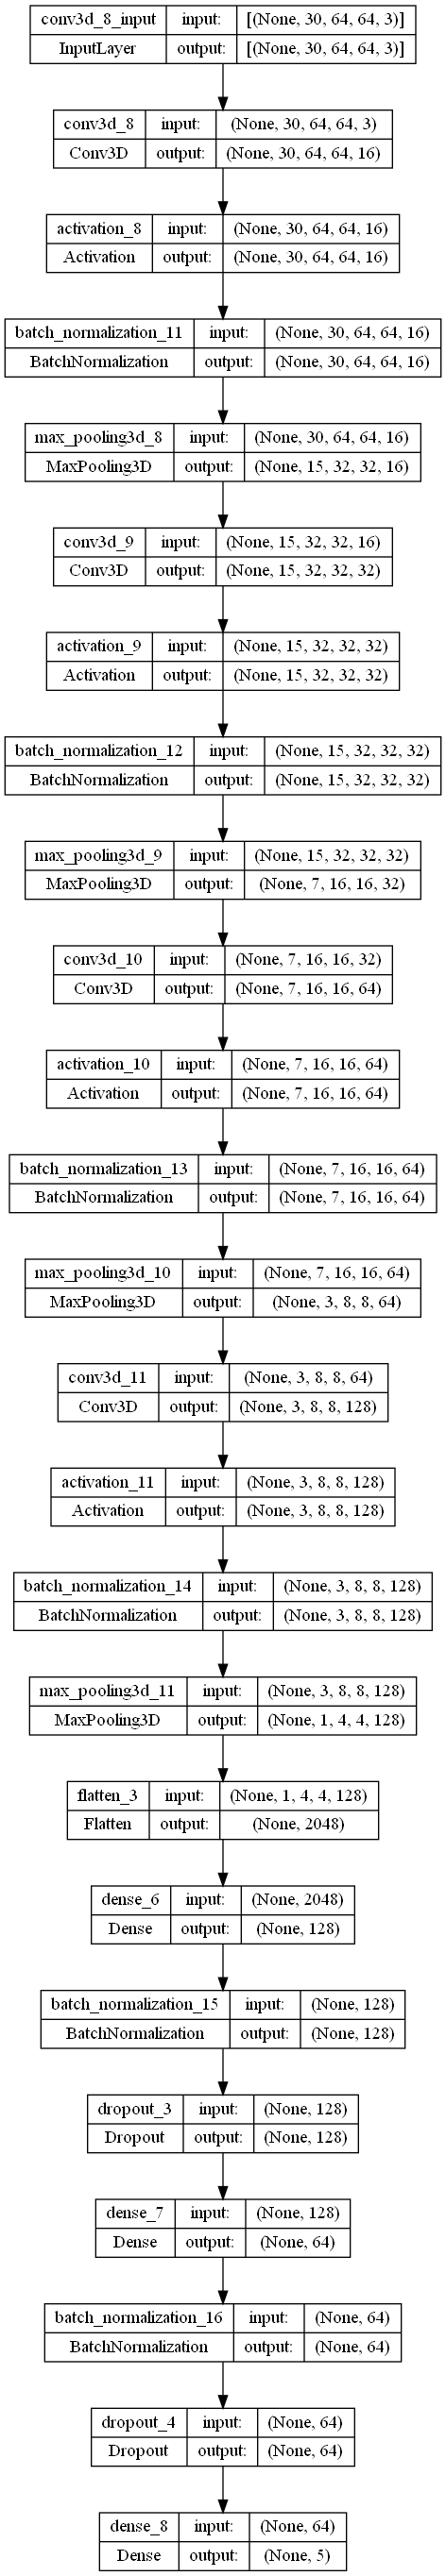

In [27]:
plot_model(model, to_file='model_3.png', show_shapes=True, show_layer_names=True)

In [28]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7135 - categorical_accuracy: 0.3454Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\val ; batch size = 8

Epoch 1: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_init_2022-07-1212_42_25.326375\model-00001-1.71351-0.34540-3.62316-0.16000.h5
83/83 [==============================] - 37s 438ms/step - loss: 1.7135 - categorical_accuracy: 0.3454 - val_loss: 3.6232 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.3062 - categorical_accuracy: 0.5038
Epoch 2: val_categorical_accuracy did not improve from 0.16000
83/83 [==============================] - 35s 432ms/step - loss: 1.3062 - categorical_accuracy: 0.5038 - val_loss: 3.5476 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
83/83 [

As expected, the above model has achieved 88% validation accuracy and 90% training accuracy for 25 epocs. Let's train the model further more 25 epocs and see if the performance increases.

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 0.2182 - categorical_accuracy: 0.9276
Epoch 1: val_categorical_accuracy did not improve from 0.88000
83/83 [==============================] - 34s 411ms/step - loss: 0.2182 - categorical_accuracy: 0.9276 - val_loss: 0.5858 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 0.2651 - categorical_accuracy: 0.9080
Epoch 2: val_categorical_accuracy did not improve from 0.88000
83/83 [==============================] - 35s 425ms/step - loss: 0.2651 - categorical_accuracy: 0.9080 - val_loss: 0.7606 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.2200 - categorical_accuracy: 0.9155
Epoch 3: val_categorical_accuracy did not improve from 0.88000
83/83 [==============================] - 35s 425ms/step - loss: 0.2200 - categorical_accuracy: 0.9155 - val_loss: 0.8717 - val_categorical_accuracy: 0.7000

Epoch 25/25
83/83 [==============================] - ETA: 0s - loss: 0.1451 - categorical_accuracy: 0.9532
Epoch 25: val_categorical_accuracy did not improve from 0.94000
83/83 [==============================] - 38s 460ms/step - loss: 0.1451 - categorical_accuracy: 0.9532 - val_loss: 0.4223 - val_categorical_accuracy: 0.9000 - lr: 0.0010


As expected, Model performance has been improved a lot. Now the model has both training and validation accuracy of about 94%. So far the best model we got is this one.

`loss: 0.1301 - categorical_accuracy: 0.9472 - val_loss: 0.1840 - val_categorical_accuracy: 0.9400 - lr: 0.0010`

As per our requirement we need to build model with lower number of parameters and the model that we have now is having only `360,133` parameters in it and it also has a great accuracy of both training and validation.

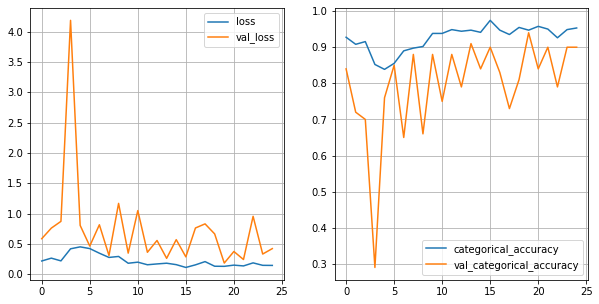

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### CNN - GRU Model

Let's try GRU Model and see if it can give more accuracy then 3D conv.

In [31]:
def CNN_GRU(seq_length=30, image_height=64, image_width=64, n_channels=3):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                                     input_shape=(seq_length,image_height,image_width,n_channels)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.50))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [32]:
batch_size = 25
num_epochs = 25
image_height = 64
image_width = 64

model = CNN_GRU(image_height=image_height, image_width=image_width)
train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps = model_params(batch_size=batch_size, num_epochs=num_epochs,image_height=image_height, image_width=image_width)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 64, 64, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 32, 32, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 32, 32, 32)  

In [33]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\train ; batch size = 25
Epoch 1/25
27/27 [==============================] - ETA: 0s - loss: 1.9547 - categorical_accuracy: 0.2293Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\val ; batch size = 25

Epoch 1: val_categorical_accuracy improved from -inf to 0.22000, saving model to model_init_2022-07-1213_13_21.723014\model-00001-1.95472-0.22926-1.83418-0.22000.h5
27/27 [==============================] - 43s 1s/step - loss: 1.9547 - categorical_accuracy: 0.2293 - val_loss: 1.8342 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.5172 - categorical_accuracy: 0.3484
Epoch 2: val_categorical_accuracy did not improve from 0.22000
27/27 [==============================] - 35s 1s/step - loss: 1.5172 - categorical_accuracy: 0.3484 - val_loss: 2.4907 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
27/27 [====

Epoch 22/25
27/27 [==============================] - ETA: 0s - loss: 0.0752 - categorical_accuracy: 0.9759
Epoch 22: val_categorical_accuracy did not improve from 0.86000
27/27 [==============================] - 44s 2s/step - loss: 0.0752 - categorical_accuracy: 0.9759 - val_loss: 0.6564 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 23/25
27/27 [==============================] - ETA: 0s - loss: 0.0817 - categorical_accuracy: 0.9759
Epoch 23: val_categorical_accuracy did not improve from 0.86000
27/27 [==============================] - 43s 2s/step - loss: 0.0817 - categorical_accuracy: 0.9759 - val_loss: 0.7904 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 24/25
27/27 [==============================] - ETA: 0s - loss: 0.0742 - categorical_accuracy: 0.9744
Epoch 24: val_categorical_accuracy did not improve from 0.86000
27/27 [==============================] - 48s 2s/step - loss: 0.0742 - categorical_accuracy: 0.9744 - val_loss: 0.8455 - val_categorical_accuracy: 0.8000 - 

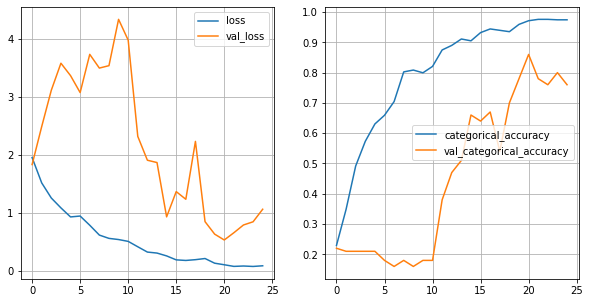

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

We can see that the model is overfitting. Lets try transfer learning.

### Transfer Learning

Lets try with the InceptionV3 model combined with GRU

In [35]:
inception_model = InceptionV3(input_shape=(128,128,3), weights='imagenet', include_top=False)

for layer in inception_model.layers:
    layer.trainable = False

In [36]:
def inception_gru(seq_length=30, image_height=64, image_width=64, n_channels=3):

    model = Sequential()

    model.add(TimeDistributed(inception_model,
                              input_shape=(seq_length,image_height,image_width,n_channels)))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.50))


    model.add(GRU(32))
    model.add(Dropout(0.50))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.50))

    model.add(Dense(5, activation='softmax'))

    return model

In [37]:
batch_size = 12
num_epochs = 25
image_height = 128
image_width = 128

model = inception_gru(image_height=image_height, image_width=image_width)
train_generator, val_generator, callbacks_list, steps_per_epoch, validation_steps = model_params(batch_size=batch_size, num_epochs=num_epochs,image_height=image_height, image_width=image_width)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 2, 2, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 2, 2, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 1, 1, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 dropout_7 (Dropout)         (None, 30, 2048)         

In [38]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\train ; batch size = 12
Epoch 1/25
56/56 [==============================] - ETA: 0s - loss: 1.7538 - categorical_accuracy: 0.2594Source path =  E:\Applications\Git\deep_learning\gesture_detection\Project_data\val ; batch size = 12

Epoch 1: val_categorical_accuracy improved from -inf to 0.42000, saving model to model_init_2022-07-1213_29_55.380790\model-00001-1.75384-0.25943-1.46012-0.42000.h5
56/56 [==============================] - 73s 1s/step - loss: 1.7538 - categorical_accuracy: 0.2594 - val_loss: 1.4601 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 2/25
56/56 [==============================] - ETA: 0s - loss: 1.5926 - categorical_accuracy: 0.3198
Epoch 2: val_categorical_accuracy did not improve from 0.42000
56/56 [==============================] - 53s 952ms/step - loss: 1.5926 - categorical_accuracy: 0.3198 - val_loss: 1.4133 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 3/25
56/56 [=

Epoch 23/25
56/56 [==============================] - ETA: 0s - loss: 0.4783 - categorical_accuracy: 0.8175
Epoch 23: val_categorical_accuracy did not improve from 0.67000
56/56 [==============================] - 52s 947ms/step - loss: 0.4783 - categorical_accuracy: 0.8175 - val_loss: 0.9014 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 24/25
56/56 [==============================] - ETA: 0s - loss: 0.4483 - categorical_accuracy: 0.8431
Epoch 24: val_categorical_accuracy did not improve from 0.67000
56/56 [==============================] - 50s 900ms/step - loss: 0.4483 - categorical_accuracy: 0.8431 - val_loss: 0.9666 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 25/25
56/56 [==============================] - ETA: 0s - loss: 0.4599 - categorical_accuracy: 0.8265
Epoch 25: val_categorical_accuracy did not improve from 0.67000
56/56 [==============================] - 57s 1s/step - loss: 0.4599 - categorical_accuracy: 0.8265 - val_loss: 0.9056 - val_categorical_accuracy: 0.6

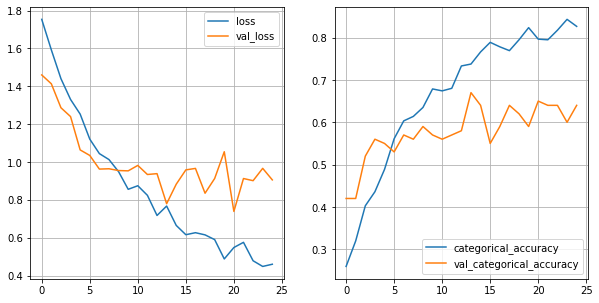

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

This model is overfitting too. May be we need to add more layers or try with little tweek of the architecture however since we are doing transfer learning here, Model might end up getting more number of parameters which we don't want as need to implement this model in webcam we need to have less number of parameters in our model but we already have 22,013,285 parameters in this inception_gru model.

*As per the business requirement we need to build the model with higher accuracy and lower number of parameters possible to detect the 5 gestures correctly so that we can implement the same in the webcam mounted on top of the TV to take control of the frequently usable action using simple gestures*

**Model-3** which is based on Conv3D architecture has lesser number of parameters and having both train and test accuracy as 94% can satisfy the business requirements

``` python

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv3d_8 (Conv3D)           (None, 30, 64, 64, 16)    1312      
                                                                 
 activation_8 (Activation)   (None, 30, 64, 64, 16)    0         
                                                                 
 batch_normalization_11 (Bat  (None, 30, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 32, 32, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 32, 32, 32)    0         
                                                                 
 batch_normalization_12 (Bat  (None, 15, 32, 32, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 16, 16, 32)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 16, 16, 64)     16448     
                                                                 
 activation_10 (Activation)  (None, 7, 16, 16, 64)     0         
                                                                 
 batch_normalization_13 (Bat  (None, 7, 16, 16, 64)    256       
 chNormalization)                                                
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 8, 8, 64)      0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 3, 8, 8, 128)      65664     
                                                                 
 activation_11 (Activation)  (None, 3, 8, 8, 128)      0         
                                                                 
 batch_normalization_14 (Bat  (None, 3, 8, 8, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 1, 4, 4, 128)     0         
 g3D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_15 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_16 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
=================================================================
Total params: 360,133
Trainable params: 359,269
Non-trainable params: 864
_________________________________________________________________

Epoch 20: val_categorical_accuracy improved from 0.91000 to 0.94000, saving model to model_init_2022-07-1212_42_25.326375\model-00020-0.13008-0.94721-0.18398-0.94000.h5
83/83 [==============================] - 42s 508ms/step - loss: 0.1301 - categorical_accuracy: 0.9472 - val_loss: 0.1840 - val_categorical_accuracy: 0.9400 - lr: 0.0010

```